In [1]:
# Bibliotecas de manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Keras (via TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Otimização de hiperparâmetros
from kerastuner.tuners import RandomSearch

# TensorFlow
import tensorflow as tf
tf.config.run_functions_eagerly(True)

C:\Users\apisa\AppData\Local\Temp\ipykernel_23900\4111964098.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
base = pd.read_csv('data_balanceado_sem_pre_diabetes.csv')
base.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity',
       'Fruits', 'Veggies', 'GenHlth', 'Sex', 'Age'],
      dtype='object')

In [3]:
X = base.drop(['Diabetes_012'], axis=1)
y = base['Diabetes_012'].astype(int).values 
print(y.shape)
print(y)
base['Diabetes_012'].value_counts()

(42448,)
[1 0 0 ... 1 0 0]


Diabetes_012
1.0    21224
0.0    21224
Name: count, dtype: int64

In [4]:
# Transformando a classe para o formato "dummy"
y = to_categorical(y, num_classes=2)
print(y.shape) 
print(y)

(42448, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizando os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
#for trial in tuner.oracle.trials.values():
 #   print(trial.metrics.metrics.keys())

### TESTANDO HIPERPARÂMETROS

In [7]:
early_stop = EarlyStopping(monitor='val_loss', restore_best_weights=True)
# Se em 40 steps, val_loss não melhora, para-se o treino
# restore_best_weights -> volta para época com melhor valor alcançado
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-8) 
# Reduz automaticamente o learning rate do otimizador quando val_loss para de melhorar de acordo com um "factor" (passo de redução)


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))  # camada de entrada

    # Hiperparâmetros
    units_1 = hp.Int('units_1', min_value=8, max_value=256, step=8)
    units_2 = hp.Int('units_2', min_value=0, max_value=128, step=4)
    dr = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)

    # Primeira camada oculta
    model.add(Dense(units_1, activation='relu'))
    if dr > 0:
        model.add(Dropout(dr))

    # Segunda camada oculta (caso haja)
    if units_2 > 0:
        model.add(Dense(units_2, activation='relu'))
        if dr > 0:
            model.add(Dropout(dr))

    # Camada de saída
    model.add(Dense(2, activation='softmax'))

    # Compilação
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # ADAM
    # 1ts momentum: ajuste linear
    # 2ts momentum: ajuste quadrático

    # Categorical Crossentropy
    # Para n classes:
    # L = - sum_i^n ylog(<y_prev>)
    return model

# Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='teste_10_sem_pre_diabetes_200',
    project_name='ajuste_rede'
)

tuner.search(X_train, y_train, epochs=200, validation_data=(X_test, y_test), 
             callbacks=[early_stop, rlr], verbose=1)

Trial 10 Complete [00h 31m 01s]
val_accuracy: 0.7356890439987183

Best val_accuracy So Far: 0.7357675433158875
Total elapsed time: 20h 03m 04s


In [8]:
# Armazenando os melhores hiperparâmetros achados

results = []

for trial in tuner.oracle.trials.values():
    metrics = trial.metrics.metrics
    if 'val_accuracy' in metrics:
        results.append({
            'Trial': trial.trial_id,
            'units_1': trial.hyperparameters.get('units_1'),
            'units_2': trial.hyperparameters.get('units_2'),
            'val_accuracy': metrics['val_accuracy'].get_last_value()
        })

df_hp_test = pd.DataFrame(results)
df_hp_test.to_csv('hp_test_2ocultas_sem_pre_diabetes_200.csv', header=True, index=False)

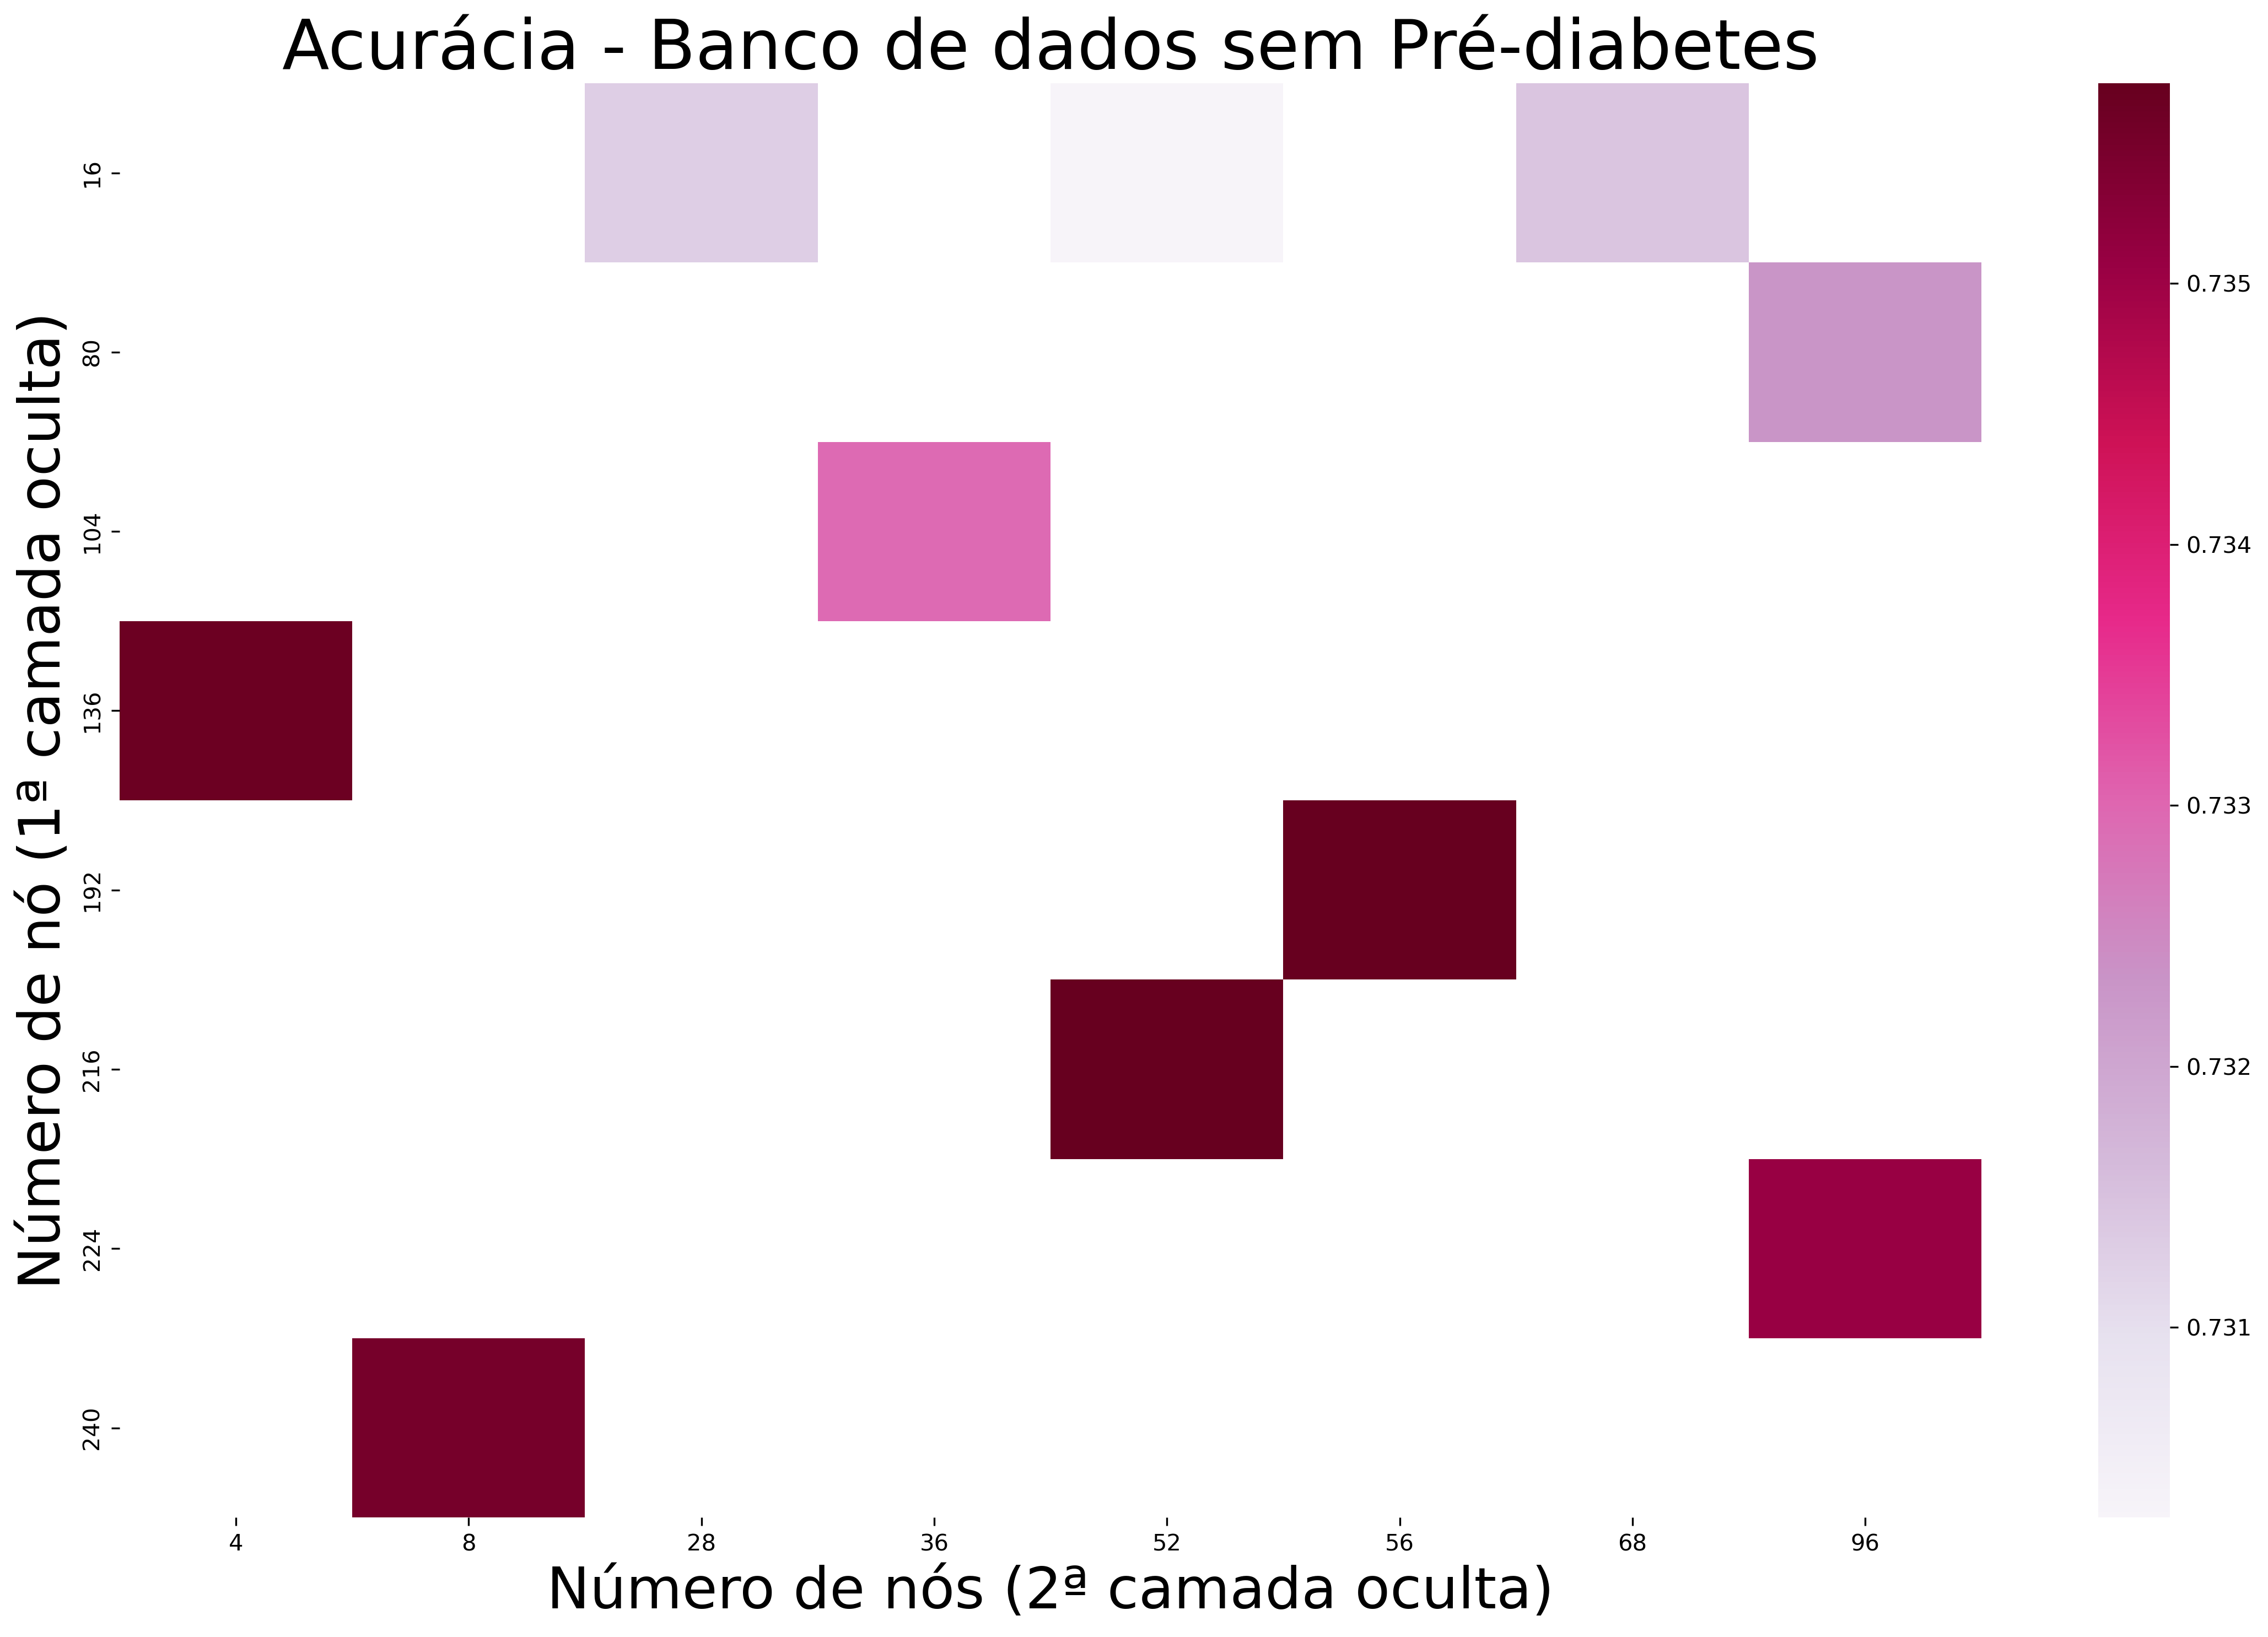

In [9]:
# Geração do heatmap para escolha dos melhores hiperparâmeros
pivot_table = df_hp_test.pivot_table(index='units_1', columns='units_2',
                             values='val_accuracy')

plt.figure(figsize=(15, 10), dpi=300)
sns.heatmap(pivot_table, annot=False, cmap='PuRd', fmt=".3f")
plt.title('Acurácia - Banco de dados sem Pré-diabetes', fontsize=30)
plt.xlabel('Número de nós (2ª camada oculta)', fontsize=25)
plt.ylabel('Número de nó (1ª camada oculta)', fontsize=25)
plt.tight_layout()
plt.savefig('hiperparametros_2ocultas_sem_pre_diabetes_200.png',dpi=300)

In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Melhores hiperparâmetros encontrados:")
print(f"units_1: {best_hps.get('units_1')}")
print(f"units_2: {best_hps.get('units_2')}")
print(f"dropout {best_hps.get('dropout')}")

Melhores hiperparâmetros encontrados:
units_1: 192
units_2: 56
dropout 0.2


In [11]:
modelo = Sequential()
modelo.add(Input(shape=(X.shape[1],)))  # camada de entrada

# Primeira camada oculta + Dropout
modelo.add(Dense(144, activation='relu'))
modelo.add(Dropout(0.2))

# Segunda camada oculta + Dropout
modelo.add(Dense(104, activation='relu'))
modelo.add(Dropout(0.2))

# Camada de saída
modelo.add(Dense(2, activation='softmax'))
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 144)               1584      
                                                                 
 dropout_2 (Dropout)         (None, 144)               0         
                                                                 
 dense_4 (Dense)             (None, 104)               15080     
                                                                 
 dropout_3 (Dropout)         (None, 104)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 210       
                                                                 
Total params: 16874 (65.91 KB)
Trainable params: 16874 (65.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Compilação
opt = Adam(learning_rate=1e-5)
modelo.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40, min_lr=1e-8)

# Treinamento
historico = modelo.fit(X_train, y_train,
                       epochs=200,
                       validation_data=(X_test, y_test),
                       callbacks=[early_stop, rlr],
                       verbose=1)


Epoch 1/200


C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 40s 43ms/step - loss: 0.6655 - accuracy: 0.5955 - val_loss: 0.6106 - val_accuracy: 0.6962 - lr: 1.0000e-05
Epoch 2/200
929/929 [==============================] - 39s 42ms/step - loss: 0.5979 - accuracy: 0.6897 - val_loss: 0.5666 - val_accuracy: 0.7206 - lr: 1.0000e-05
Epoch 3/200
929/929 [==============================] - 41s 45ms/step - loss: 0.5702 - accuracy: 0.7102 - val_loss: 0.5495 - val_accuracy: 0.7230 - lr: 1.0000e-05
Epoch 4/200
929/929 [==============================] - 40s 43ms/step - loss: 0.5596 - accuracy: 0.7152 - val_loss: 0.5432 - val_accuracy: 0.7260 - lr: 1.0000e-05
Epoch 5/200
929/929 [==============================] - 41s 44ms/step - loss: 0.5556 - accuracy: 0.7203 - val_loss: 0.5407 - val_accuracy: 0.7282 - lr: 1.0000e-05
Epoch 6/200
929/929 [==============================] - 38s 41ms/step - loss: 0.5530 - accuracy: 0.7195 - val_loss: 0.5394 - val_accuracy: 0.7292 - lr: 1.0000e-05
Epoch 7/200
929/929 [===================

929/929 [==============================] - 39s 42ms/step - loss: 0.5413 - accuracy: 0.7284 - val_loss: 0.5336 - val_accuracy: 0.7362 - lr: 1.0000e-05
Epoch 52/200
929/929 [==============================] - 44s 47ms/step - loss: 0.5405 - accuracy: 0.7268 - val_loss: 0.5336 - val_accuracy: 0.7358 - lr: 1.0000e-05
Epoch 53/200
929/929 [==============================] - 38s 41ms/step - loss: 0.5398 - accuracy: 0.7287 - val_loss: 0.5336 - val_accuracy: 0.7356 - lr: 1.0000e-05
Epoch 54/200
929/929 [==============================] - 43s 46ms/step - loss: 0.5406 - accuracy: 0.7316 - val_loss: 0.5336 - val_accuracy: 0.7355 - lr: 1.0000e-05
Epoch 55/200
929/929 [==============================] - 40s 43ms/step - loss: 0.5397 - accuracy: 0.7284 - val_loss: 0.5335 - val_accuracy: 0.7358 - lr: 1.0000e-05
Epoch 56/200
929/929 [==============================] - 45s 49ms/step - loss: 0.5409 - accuracy: 0.7275 - val_loss: 0.5335 - val_accuracy: 0.7358 - lr: 1.0000e-05
Epoch 57/200
929/929 [=============

929/929 [==============================] - 40s 43ms/step - loss: 0.5387 - accuracy: 0.7289 - val_loss: 0.5331 - val_accuracy: 0.7350 - lr: 1.0000e-05
Epoch 102/200
929/929 [==============================] - 41s 44ms/step - loss: 0.5380 - accuracy: 0.7311 - val_loss: 0.5331 - val_accuracy: 0.7347 - lr: 1.0000e-05
Epoch 103/200
929/929 [==============================] - 42s 45ms/step - loss: 0.5372 - accuracy: 0.7295 - val_loss: 0.5331 - val_accuracy: 0.7350 - lr: 1.0000e-05
Epoch 104/200
929/929 [==============================] - 40s 43ms/step - loss: 0.5385 - accuracy: 0.7299 - val_loss: 0.5332 - val_accuracy: 0.7349 - lr: 1.0000e-05
Epoch 105/200
929/929 [==============================] - 38s 41ms/step - loss: 0.5373 - accuracy: 0.7296 - val_loss: 0.5331 - val_accuracy: 0.7348 - lr: 1.0000e-05
Epoch 106/200
929/929 [==============================] - 42s 45ms/step - loss: 0.5372 - accuracy: 0.7301 - val_loss: 0.5331 - val_accuracy: 0.7350 - lr: 1.0000e-05
Epoch 107/200
929/929 [=======

929/929 [==============================] - 37s 40ms/step - loss: 0.5360 - accuracy: 0.7320 - val_loss: 0.5329 - val_accuracy: 0.7344 - lr: 1.0000e-05
Epoch 152/200
929/929 [==============================] - 37s 39ms/step - loss: 0.5360 - accuracy: 0.7295 - val_loss: 0.5329 - val_accuracy: 0.7347 - lr: 1.0000e-05
Epoch 153/200
929/929 [==============================] - 37s 40ms/step - loss: 0.5349 - accuracy: 0.7314 - val_loss: 0.5329 - val_accuracy: 0.7351 - lr: 1.0000e-05
Epoch 154/200
929/929 [==============================] - 38s 40ms/step - loss: 0.5361 - accuracy: 0.7320 - val_loss: 0.5329 - val_accuracy: 0.7347 - lr: 1.0000e-05
Epoch 155/200
929/929 [==============================] - 37s 40ms/step - loss: 0.5355 - accuracy: 0.7339 - val_loss: 0.5328 - val_accuracy: 0.7352 - lr: 1.0000e-05
Epoch 156/200
929/929 [==============================] - 40s 43ms/step - loss: 0.5360 - accuracy: 0.7298 - val_loss: 0.5328 - val_accuracy: 0.7349 - lr: 1.0000e-05
Epoch 157/200
929/929 [=======

### MÉTRICAS

In [13]:
# Avaliar o desempenho no conjunto de teste
# Aqui testa o desempenho da rede com dados que ela nunca viu.
# O valor impresso é a acurácia final no conjunto de teste.

loss, accuracy = modelo.evaluate(X_test, y_test)
print(f'Acurácia no teste: {accuracy * 100:.2f}%')

398/398 [==============================] - 11s 28ms/step - loss: 0.5328 - accuracy: 0.7355
Acurácia no teste: 73.55%


In [14]:
# Predição
# Obtenção das probabilidades sobre o conjunto teste
y_pred_probs = modelo.predict(X_test)

# Converter de one-hot para rótulos (índices das classes)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

398/398 [==============================] - 4s 10ms/step


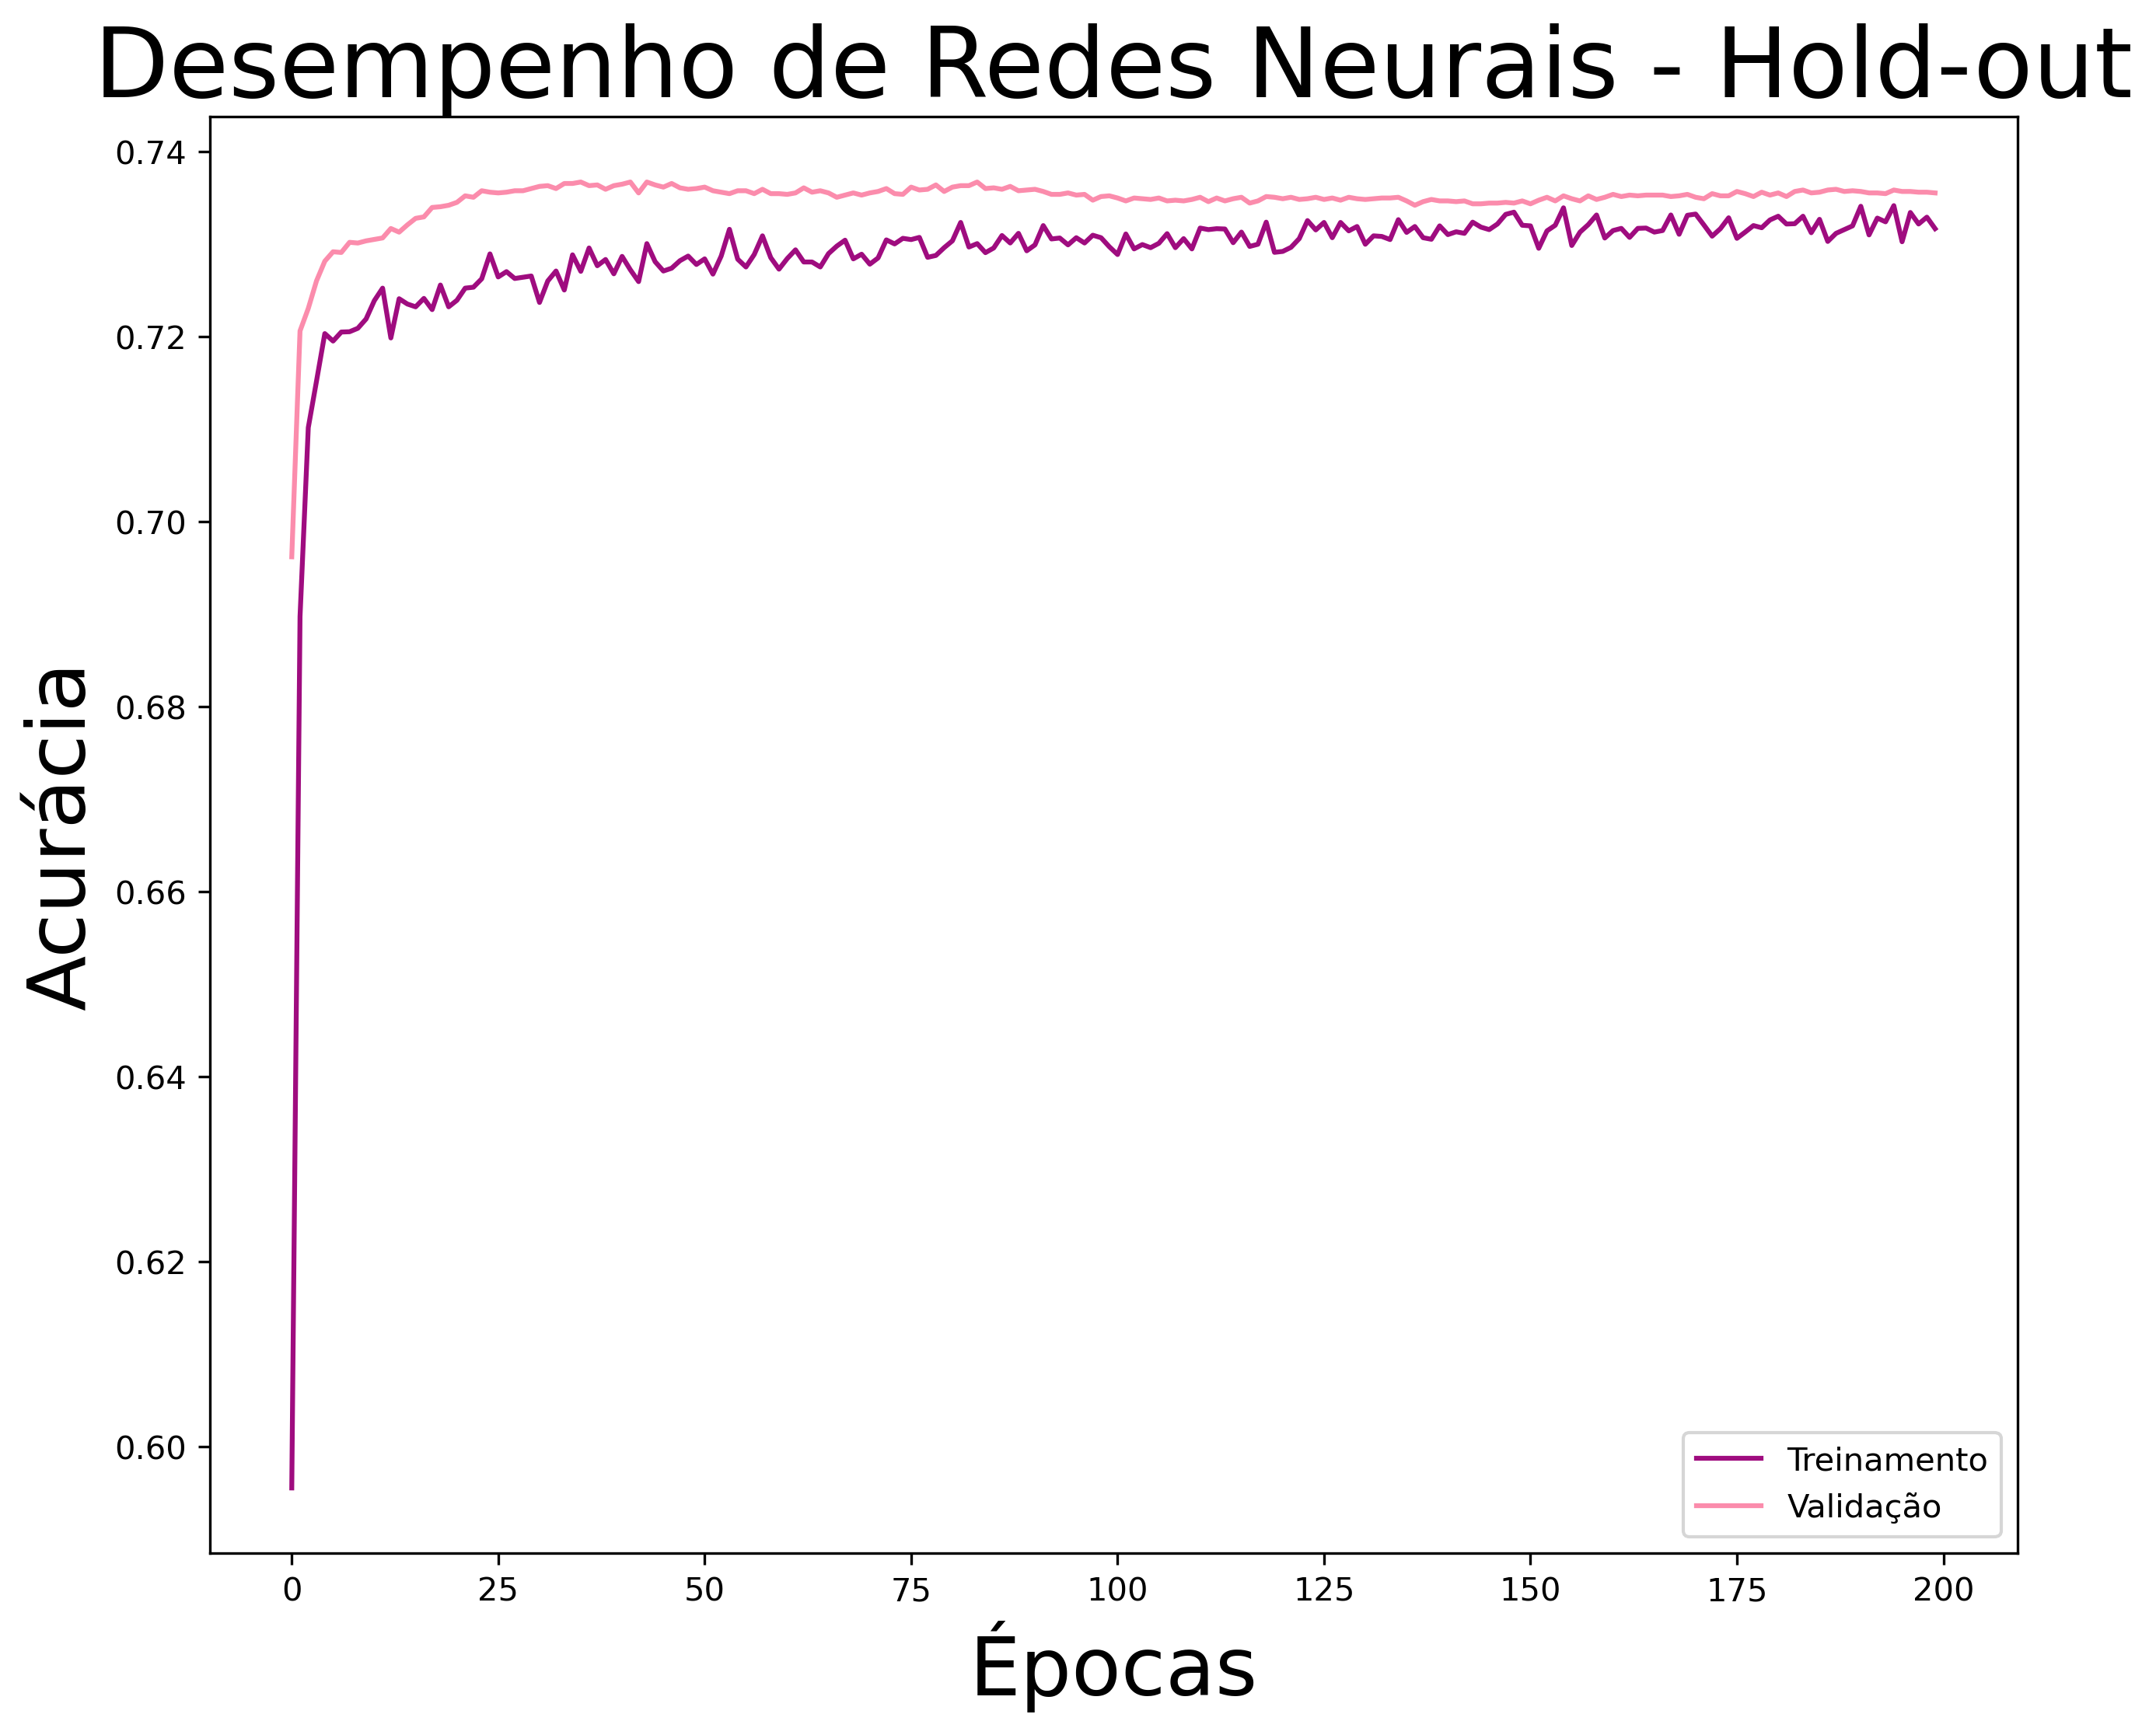

In [19]:
# Visualizar o desempenho durante o treinamento
# O gráfico mostra como a acurácia da rede foi evoluindo ao longo do treinamento:
# Linha azul: acurácia durante o treino
# Linha laranja: acurácia durante a validação
# Se as duas linhas sobem e ficam estáveis, o modelo está aprendendo bem.

plt.figure(figsize=(10, 8), dpi=300)
plt.plot(historico.history['accuracy'], label='Treinamento', color='#9f0c7f')
plt.plot(historico.history['val_accuracy'], label='Validação', color='#fb8cac')
plt.xlabel('Épocas', fontsize=25)
plt.ylabel('Acurácia', fontsize=25)
plt.legend()
plt.title('Desempenho de Redes Neurais - Hold-out', fontsize=30)
plt.savefig('desempenho_rede_neural_holdout.png',dpi=300)

In [16]:
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, digits=4))


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.7707    0.6799    0.7224      6447
           1     0.7072    0.7926    0.7475      6288

    accuracy                         0.7355     12735
   macro avg     0.7389    0.7362    0.7349     12735
weighted avg     0.7393    0.7355    0.7348     12735



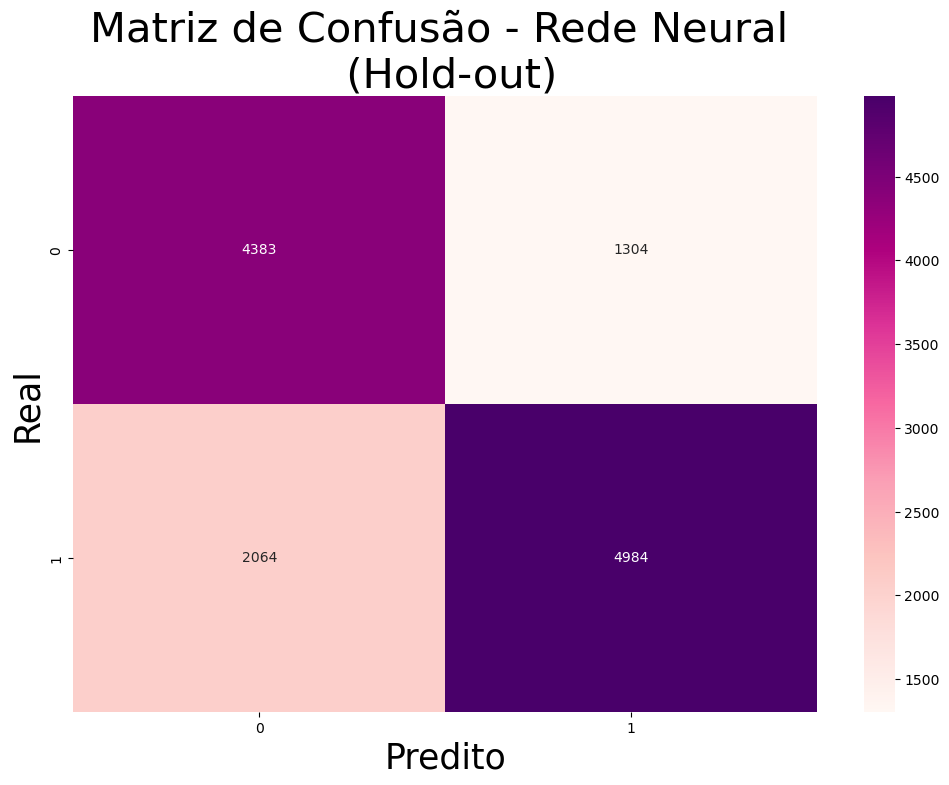

In [17]:
# Geração da matriz de confusão
confusao = confusion_matrix(y_pred, y_true)
confusao

plt.figure(figsize=(12, 8))
sns.heatmap(confusao, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("Predito", fontsize=25)
plt.ylabel("Real", fontsize=25)
plt.title("Matriz de Confusão - Rede Neural \n (Hold-out)", fontsize=30)
plt.savefig('matriz_confusao_rede_neural_holdout.png',dpi=300)

### CURVA ROC

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


398/398 [==============================] - 4s 11ms/step


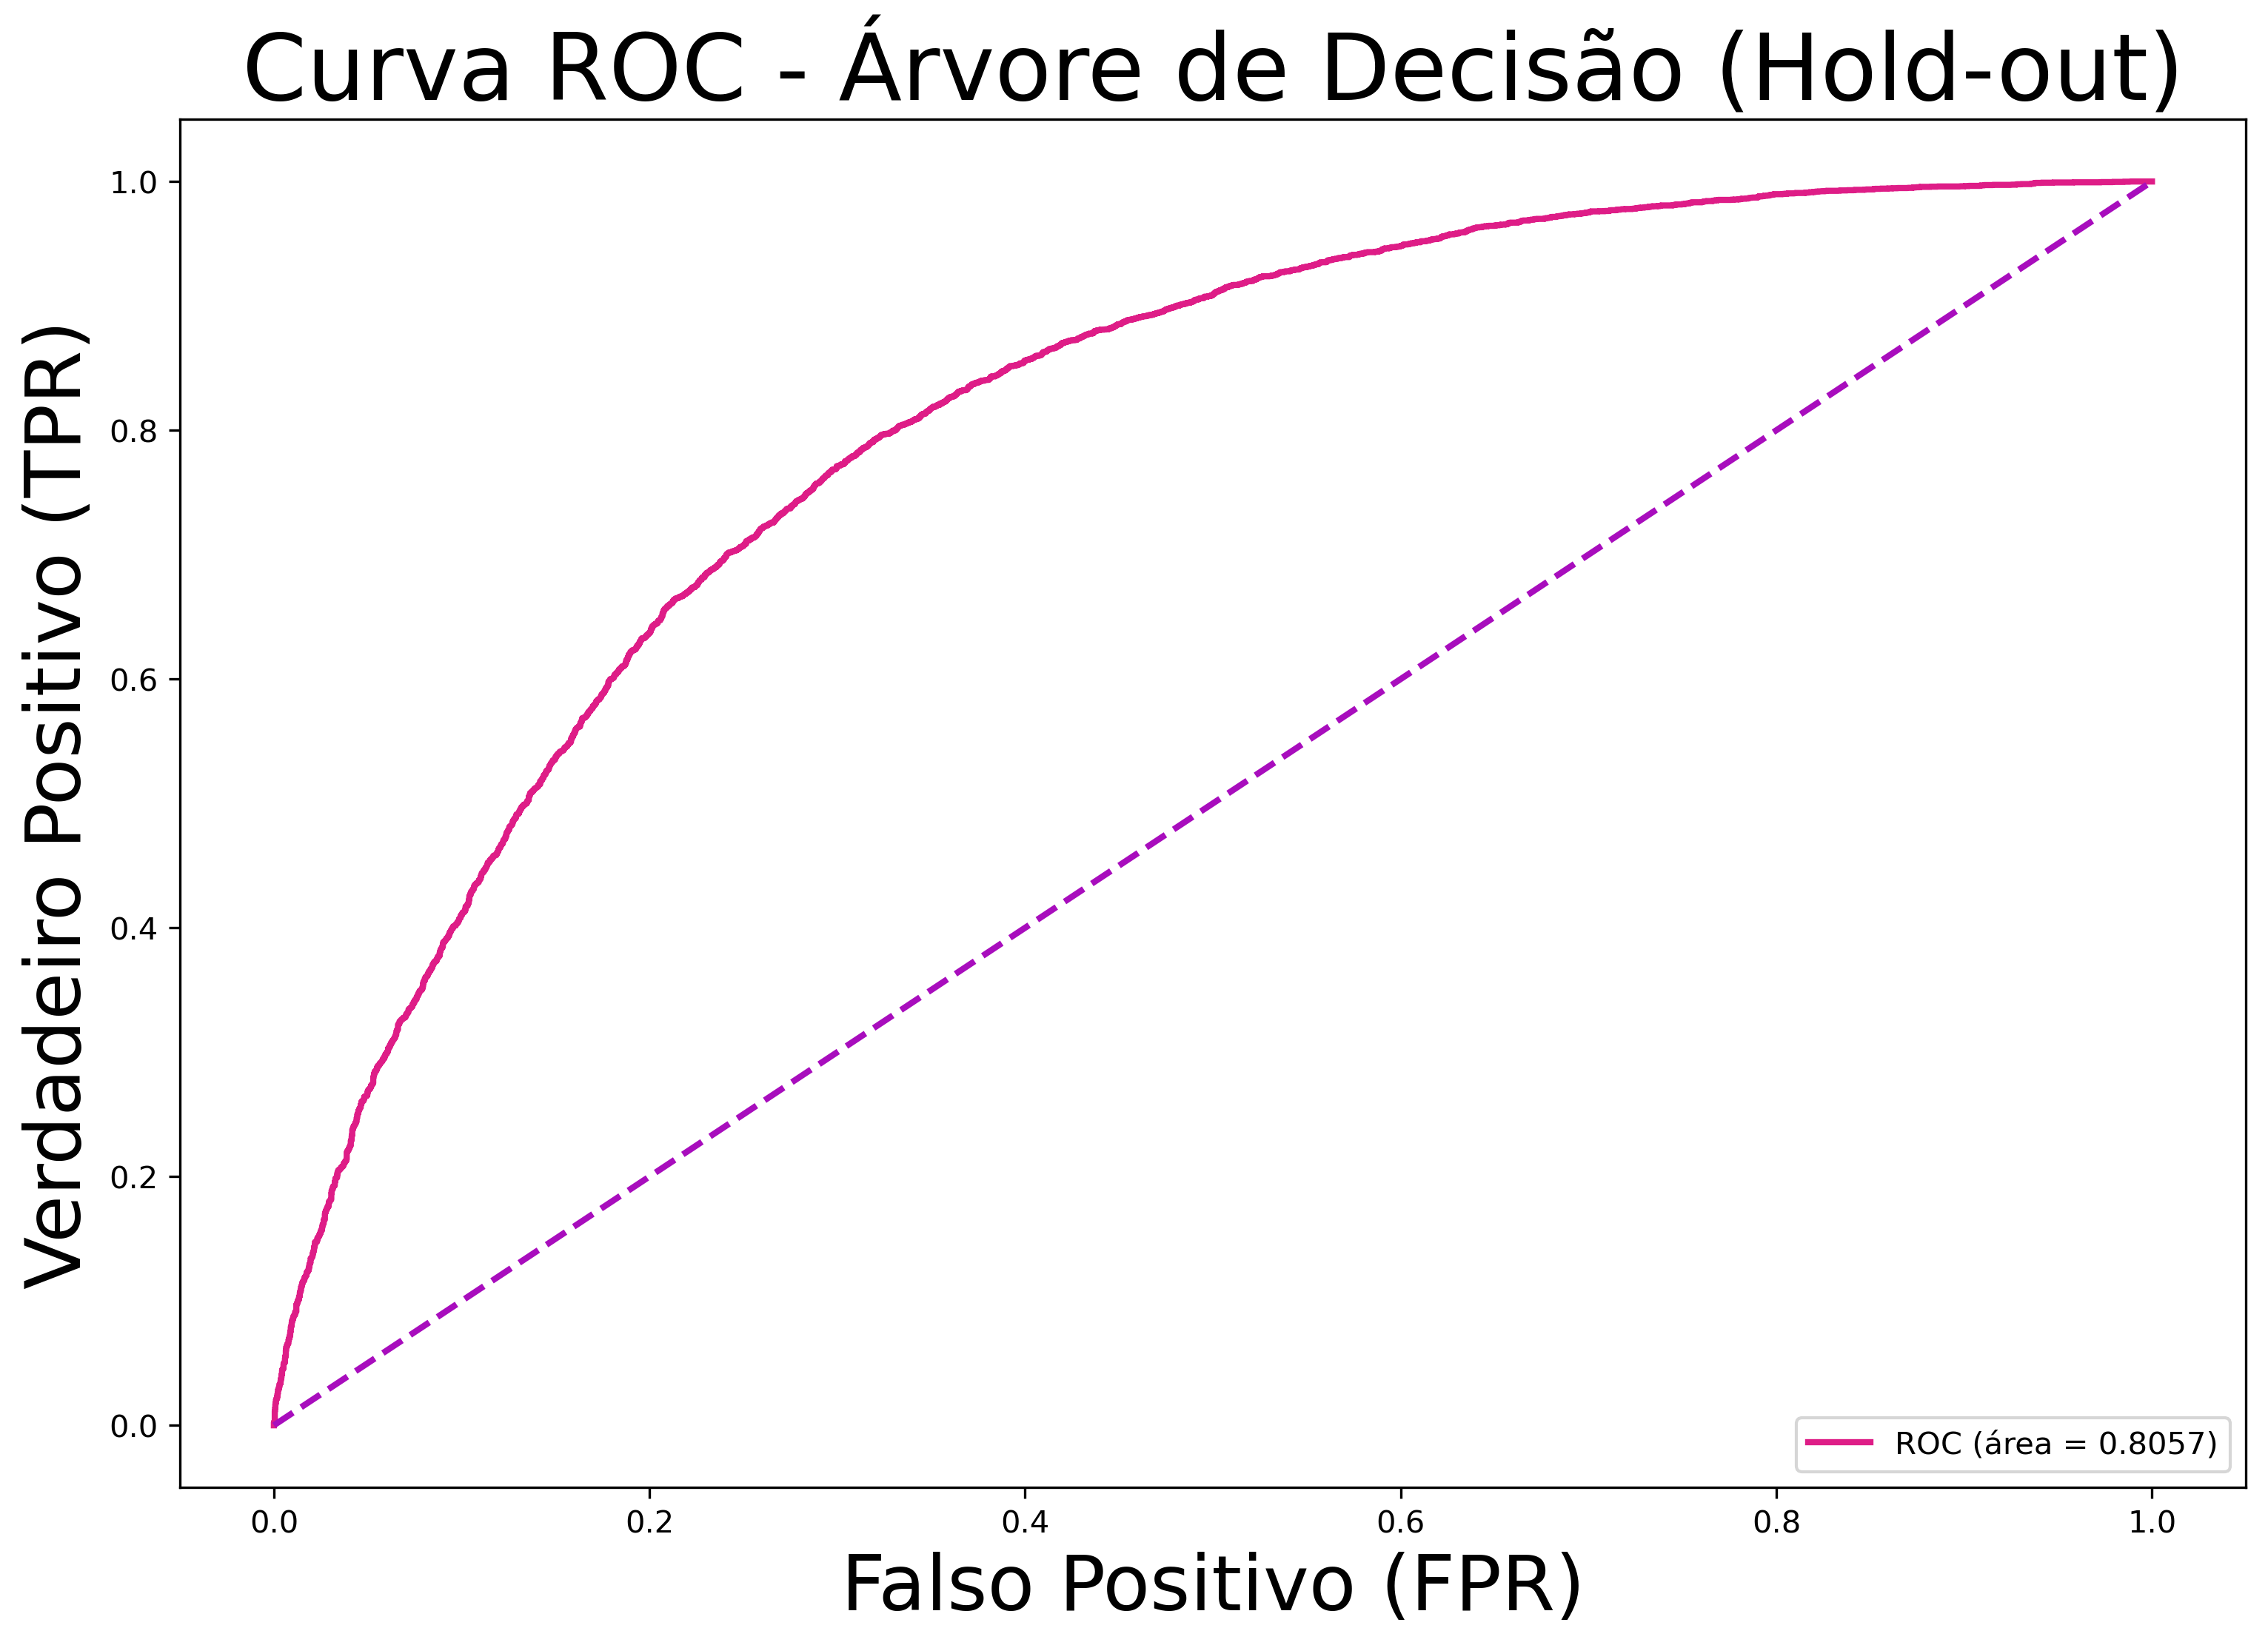

In [20]:
# Converter de one-hot para rótulos
y_true = np.argmax(y_test, axis=1)

# Probabilidades previstas para a classe positiva (1)
y_prob = modelo.predict(X_test)[:, 1]

# Calcula FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_prob)  # <- usar y_true, não y_test

# Calcula a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(12, 8), dpi=300)
plt.plot(fpr, tpr, color='#de1d87', lw=2, label=f'ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#a80dbd', lw=2, linestyle='--')  # linha de referência
plt.xlabel('Falso Positivo (FPR)', fontsize=25)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=25)
plt.title('Curva ROC - Árvore de Decisão (Hold-out)', fontsize=30)
plt.legend(loc="lower right")
plt.savefig("decision_tree_curva_roc_holdout.png", dpi=300)
